# Personal Information
Name: **Wouter Knibbe**

StudentID: **12795526**

Email: [**wouter.knibbe@student.uva.nl**](wouter.knibbe@student.uva.nl)

Submitted on: **05.03.2024**

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

My research is not a traditional DS master thesis subject with a dataset provided by a company, so I will provide some context: In my research I will be hill climbing for hardness on the Asymmetric Traveling Salesman Problem (ATSP). ATSP is the optimization problem of finding the shortest path that connects a set of nodes in a fully connected weighted graph in such a way that each node is visited exactly once. I will challenge an ATSP solver by creating harder and harder problem instances for it. I do this for 500 iterations, and for each of them I save the problem instance, how hard it was, etc. to create my own dataset. Subsequently, I calculate various characteristics of the problem instances to find relationships between them and the instance's difficulty ('hardness' in the literature). The research aims to clarify which characteristics could predict the hardness of an instance in the combinatorial problem overall. Finding such predictors has great benefits for various real world applications using ATSP every day. The solver is the Python implementation of Little's algorithm published by a previous researcher. 

# Data Description

### Data Generation

A Python implementation by Sleegers et al. of Little's algorithm.

In [2]:
import algorithm

The input for the algorithm is a distance matrix, which represents the distance to and from each city. The matrix in this version of TSP is asymmetric, which means that the distance from city A to city B does not have to be the same as from city B to city A.

I use ints because I vary by the problem instances by city size but also *value ranges*. If I were to use floats, the amount of possible distance matrices would be equal for all value ranges. Then, they are converted to floats to allow for np.inf. I want np.inf to negate the possibility of travelling from one city to itself because it is never an option we want to consider in this version of TSP.

In [3]:
amount_of_cities = 4
matrix = np.random.randint(1,10,((amount_of_cities, amount_of_cities))).astype(float)
for i in range(amount_of_cities):
    matrix[i, i] = np.inf
matrix

array([[inf,  2.,  5.,  5.],
       [ 5., inf,  3.,  4.],
       [ 4.,  4., inf,  5.],
       [ 1.,  4.,  5., inf]])

In [4]:
iterations, optimal_tour, optimal_cost = algorithm.get_minimal_route(matrix)
iterations, optimal_tour, optimal_cost.round(1)

(2, [(0, 1), (1, 2), (2, 3), (3, 0)], 11.0)

Custom mutation function. Simply mutates a single number in the matrix. Ensures that the number indeed does become another number.

In [5]:
def mutate_matrix(_matrix, _upper, _print):
    matrix = _matrix.copy()
    number1, number2 = 0, 0

    while number1 == number2:
        number1, number2 = np.random.randint(0,matrix.shape[0]), np.random.randint(0,matrix.shape[0])
    previous_number = matrix[number1,number2]
    while matrix[number1,number2] == previous_number:
        matrix[number1,number2] = np.random.randint(1,_upper)
    if _print:
        print(_matrix[number1,number2].round(1), "at", (number1,number2), "becomes", matrix[number1,number2].round(1))

    return matrix

print(matrix.round(1))
print(mutate_matrix(matrix, 10, True).round(1))

[[inf  2.  5.  5.]
 [ 5. inf  3.  4.]
 [ 4.  4. inf  5.]
 [ 1.  4.  5. inf]]
5.0 at (3, 2) becomes 4.0
[[inf  2.  5.  5.]
 [ 5. inf  3.  4.]
 [ 4.  4. inf  5.]
 [ 1.  4.  4. inf]]


#### The experiment
Involves calculating the hardness for a problem with a set amount of cities and value ranges. Then the distance matrix is hillclimbed for hardness through mutating one random number each iteration. It takes in: amounts of cities (list), value ranges (list), and amount of mutations (int).

In [6]:
def experiment(_cities, _ranges, _mutations):
    for citysize in _cities:
        for rang in _ranges:
            range_results = {}
            hardest = 0
            
            # initialize the matrix with ints, but convert it to a floating-point type to enable np.inf
            matrix = np.random.randint(1,rang,((citysize, citysize))).astype(float)
            for x in range(citysize):
                matrix[x, x] = np.inf
            hardest_matrix = matrix
            
            for j in range(_mutations):
                iterations, optimal_tour, optimal_cost = algorithm.get_minimal_route(matrix)
                # save results of interest
                # in order: iterations Little took on this instance, hardest instance so far, 
                # optimal_tour, optimal_cost, matrix
                range_results[j] = (iterations, hardest, optimal_tour, optimal_cost, matrix)
                
                # hillclimb
                # only considers the current mutation harder if it has MORE iterations
                if iterations > hardest:
                    hardest_matrix = matrix
                    matrix = mutate_matrix(hardest_matrix, rang, False)
                    hardest = iterations
                else:
                    matrix = mutate_matrix(hardest_matrix, rang, False)
            
            # save to json file
            save_partial(range_results, citysize, rang)

In [7]:
# an example experiment
# experiment([12, 15], [10,1000], 500)

Sometimes I get the below error, and I don't know why. I notified the creator but he does not know either, says it could be a bug.

```
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[19], line 1
----> 1 results = experiment([8], [10,1000], 500)

Cell In[6], line 11
      9 hardest_matrix = matrix
     10 for j in range(_mutations):
---> 11     iterations, optimal_tour, optimal_cost = algorithm.get_minimal_route(matrix)
     12     range_results[j] = (iterations, hardest, optimal_tour, optimal_cost, matrix)
     13     if iterations > hardest:

File c:\Users\User\Documents\0-Werk\Studie\Data Science\Scriptie\Experiment\algorithm.py:488, in get_minimal_route(initial_matrix)
    485 if (matrix_child2.count() == 4):
    486   zero_indices = np.where(matrix_child2 == 0)
    487   finished_up = [(zero_indices[0][0], zero_indices[1][0]),
--> 488     (zero_indices[0][1], zero_indices[1][1])]
    490   best_tour = get_best_tour(best_tour, child2, finished_up)
    491 else:

IndexError: index 1 is out of bounds for axis 0 with size 1
```

I'm still in the process of debugging. I changed the code of interest to the following to find the issue.

```
try:
        # Your existing code that might raise an IndexError
        if (matrix_child2.count() == 4):
            zero_indices = np.where(matrix_child2 == 0)
            finished_up = [(zero_indices[0][0], zero_indices[1][0]),
                           (zero_indices[0][1], zero_indices[1][1])]
            best_tour = get_best_tour(best_tour, child2, finished_up)
        else:
          heapq.heappush(priority_queue, child1)
          heapq.heappush(priority_queue, child2)

    except IndexError as e:
        print("Caught an IndexError: ", e)
        print("zero_indices: ", zero_indices)
        try:
            print("Trying to print complex expression: "), 
            print(zero_indices[0][0]),
            print(zero_indices[1][0]), 
            print(zero_indices[0][1]), 
            print(zero_indices[1][1])
        except IndexError as e:
            print("An error occurred while printing the complex expression: ", e)
        raise  
```

### Data Saving

In [8]:
def custom_encoder(obj):
    """
    Custom JSON encoder function that converts non-serializable objects.
    Converts:
    - numpy arrays to lists
    - numpy int64 to int
    - numpy float64 to float
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.inf):
        return "np.inf"
    else:
        # This will raise a TypeError for unknown types
        raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")

def save_partial(results, citysize, range):

    x = 0
    while True:
        file_path = f"results{citysize}_{range}_{x}.json"
        if not os.path.exists(file_path):
            break
        x += 1

    # Dumping the nested_dict to a json file with custom encoding
    with open(file_path, "w") as json_file:
        json.dump(results, json_file, default=custom_encoder)

    print(f"Results saved to JSON file successfully as {file_path}")

### Data Loading

In [9]:
def custom_decoder(obj):
    """
    Custom decoder function that converts specific JSON values back to their original types.
    Converts:
    - 'Infinity' to np.inf
    """
    if isinstance(obj, dict):
        for key, value in obj.items():
            if value == "Infinity":
                obj[key] = np.inf
            # elif isinstance(value, list):
                # Convert lists back to arrays
                # obj[key] = np.array(value)
            elif isinstance(value, dict):
                obj[key] = custom_decoder(value)
    elif isinstance(obj, list):
        for i, value in enumerate(obj):
            if value == "Infinity":
                obj[i] = np.inf
            # elif isinstance(value, list):
                # obj[i] = np.array(value)
            elif isinstance(value, dict):
                obj[i] = custom_decoder(value)
    return obj

def load_result(file_path):

  # Loading the JSON file with custom decoding
  with open(file_path, "r") as json_file:
      loaded_results = json.load(json_file, object_hook=custom_decoder)

  return loaded_results

### Analysis 1: Structure of the files


In [10]:
path = f"Results/results10_1000_0.json"
loaded = load_result(path)
print(f"The first keys are the iterations. \n {list(loaded.keys())[:3]} ... {list(loaded.keys())[-3:]}")

The first keys are the iterations. 
 ['0', '1', '2'] ... ['497', '498', '499']


In [11]:
print(f"Little took {loaded['4'][0]} iterations on this instance.")
print(f"The hardest instance so far took Little {loaded['4'][1]} iterations.")
print(f"The optimal tour for this instance was \n {np.asarray(loaded['4'][2])} \n which had a cost of {round(loaded['4'][3],2)}.\n")
print(f"Its respective (rounded) matrix was \n {np.asarray(loaded['4'][4]).round(0)}")

Little took 22 iterations on this instance.
The hardest instance so far took Little 23 iterations.
The optimal tour for this instance was 
 [[7 3]
 [3 4]
 [2 1]
 [1 0]
 [8 9]
 [6 2]
 [0 5]
 [5 8]
 [4 6]
 [9 7]] 
 which had a cost of 1776.0.

Its respective (rounded) matrix was 
 [[ inf 301. 345. 896. 759.  51. 972. 797. 275. 903.]
 [186.  inf 530. 372. 814. 301. 690. 190. 462. 863.]
 [517.  70.  inf 698. 370. 962. 369. 384. 853. 949.]
 [654. 138. 348.  inf 210. 500. 740. 819. 672. 312.]
 [ 88. 758.  86. 575.  inf 482. 501. 499. 752. 983.]
 [302. 987. 681. 568. 629.  inf 989. 678.  66. 195.]
 [415. 764.  15. 557. 383. 743.  inf 956. 680. 931.]
 [466. 991. 240. 135. 332. 372. 397.  inf 892. 369.]
 [313. 176. 612. 678. 725. 118. 682. 930.  inf  88.]
 [540. 527. 119. 873. 242. 923. 929. 454. 495.  inf]]


In [12]:
import pandas as pd

df = pd.DataFrame.from_dict(loaded).T
df = df.rename(columns={0: "Current mutation", 1: "Hardest mutation",
                        2: "Optimal tour", 3: "Optimal cost", 4: "Matrix"})
df

,Current mutation,Hardest mutation,Optimal tour,Optimal cost,Matrix
0,19,0,"[[4, 6], [0, 5], [3, 8], [9, 4], [2, 1], [6, 2...",1920.0,"[[inf, 301.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
1,18,19,"[[7, 3], [8, 0], [9, 4], [3, 8], [5, 9], [0, 5...",1920.0,"[[inf, 301.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
2,17,19,"[[4, 6], [0, 5], [3, 8], [9, 4], [2, 1], [6, 2...",1920.0,"[[inf, 301.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
3,23,19,"[[7, 3], [3, 4], [2, 1], [1, 0], [5, 8], [8, 9...",1776.0,"[[inf, 301.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
4,22,23,"[[7, 3], [3, 4], [2, 1], [1, 0], [8, 9], [6, 2...",1776.0,"[[inf, 301.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
...,...,...,...,...,...
495,101,113,"[[2, 8], [4, 6], [1, 0], [9, 4], [3, 1], [7, 3...",1964.0,"[[inf, 236.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
496,111,113,"[[2, 8], [4, 6], [1, 0], [9, 4], [3, 1], [7, 3...",1964.0,"[[inf, 236.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
497,112,113,"[[2, 8], [4, 6], [1, 0], [9, 4], [3, 1], [7, 3...",1964.0,"[[inf, 236.0, 345.0, 896.0, 759.0, 51.0, 972.0..."
498,111,113,"[[2, 8], [4, 6], [1, 0], [9, 4], [3, 1], [7, 3...",1964.0,"[[inf, 236.0, 345.0, 896.0, 759.0, 51.0, 972.0..."


### Analysis 2: Visual inspection of the hardest and easiest matrices


In [13]:
print("Easiest")
display(df[df["Current mutation"] == df["Current mutation"].min()]["Matrix"][0])
print("Hardest")
display(df[df["Current mutation"] == df["Current mutation"].max()]["Matrix"][0])

Easiest


[[inf, 301.0, 345.0, 896.0, 759.0, 51.0, 972.0, 797.0, 275.0, 903.0],
 [186.0, inf, 530.0, 372.0, 814.0, 301.0, 690.0, 190.0, 462.0, 863.0],
 [517.0, 70.0, inf, 698.0, 370.0, 962.0, 369.0, 384.0, 853.0, 949.0],
 [654.0, 138.0, 348.0, inf, 210.0, 500.0, 740.0, 819.0, 208.0, 312.0],
 [88.0, 758.0, 86.0, 575.0, inf, 482.0, 501.0, 499.0, 752.0, 983.0],
 [302.0, 987.0, 681.0, 568.0, 629.0, inf, 989.0, 678.0, 66.0, 195.0],
 [415.0, 764.0, 15.0, 557.0, 383.0, 743.0, inf, 956.0, 680.0, 931.0],
 [466.0, 991.0, 240.0, 135.0, 332.0, 372.0, 397.0, inf, 892.0, 369.0],
 [313.0, 176.0, 612.0, 678.0, 725.0, 118.0, 682.0, 930.0, inf, 88.0],
 [540.0, 527.0, 119.0, 873.0, 242.0, 923.0, 528.0, 454.0, 495.0, inf]]

Hardest


[[inf, 236.0, 345.0, 896.0, 759.0, 51.0, 972.0, 797.0, 275.0, 367.0],
 [186.0, inf, 530.0, 372.0, 814.0, 121.0, 474.0, 190.0, 462.0, 863.0],
 [517.0, 70.0, inf, 420.0, 370.0, 962.0, 369.0, 384.0, 159.0, 300.0],
 [422.0, 138.0, 44.0, inf, 210.0, 500.0, 740.0, 366.0, 208.0, 312.0],
 [88.0, 250.0, 86.0, 692.0, inf, 146.0, 516.0, 403.0, 396.0, 233.0],
 [302.0, 987.0, 681.0, 568.0, 629.0, inf, 989.0, 678.0, 203.0, 195.0],
 [415.0, 764.0, 63.0, 557.0, 383.0, 743.0, inf, 956.0, 450.0, 609.0],
 [116.0, 991.0, 953.0, 135.0, 999.0, 372.0, 397.0, inf, 28.0, 52.0],
 [546.0, 176.0, 612.0, 678.0, 725.0, 47.0, 682.0, 279.0, inf, 88.0],
 [222.0, 527.0, 119.0, 873.0, 242.0, 923.0, 929.0, 454.0, 495.0, inf]]

Not very obvious how they differ. They share many values

### Analysis 3: Plotting the hardness

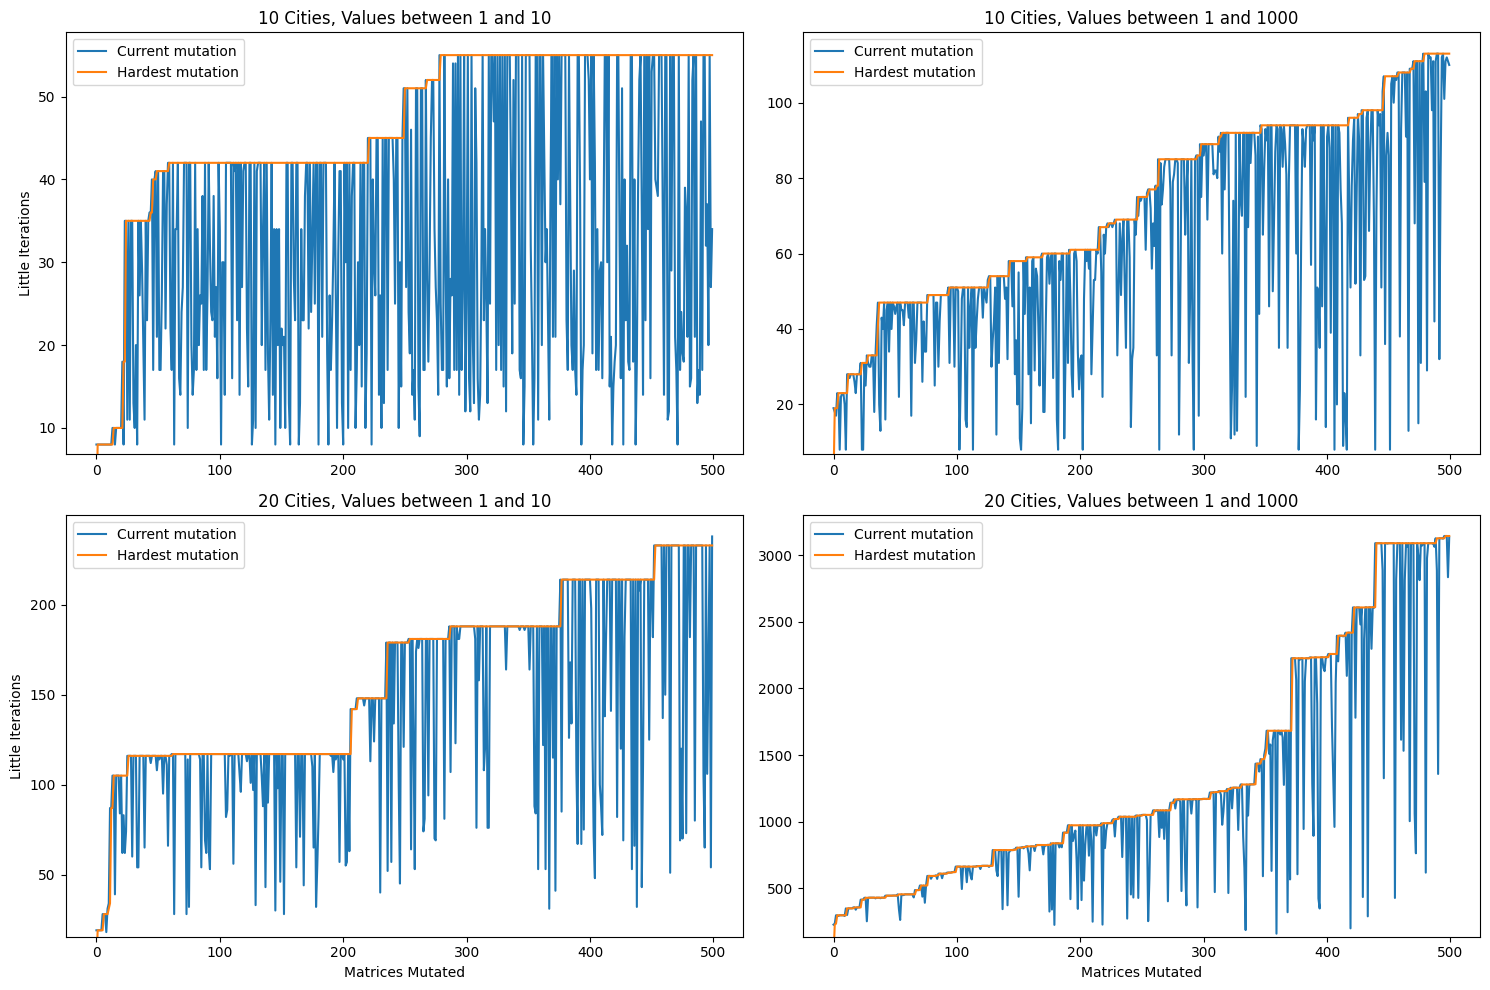

In [14]:
cities = [10, 20]
ranges = [10, 1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)
        
        x_values = list(loaded.keys())
        y_values_0 = [values[0] for values in loaded.values()]  
        y_values_1 = [values[1] for values in loaded.values()] 
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j]

        ax.plot(x_values, y_values_0, label='Current mutation')
        ax.plot(x_values, y_values_1, label='Hardest mutation')

        ax.set_xticks(list(range(0,600,100)))
        ax.set_xticklabels(list(range(0,600,100)))

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if j == 0:
          ax.set_ylabel('Little Iterations')
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()

plt.tight_layout()
plt.show()

### Analysis 4: Characteristics on the data

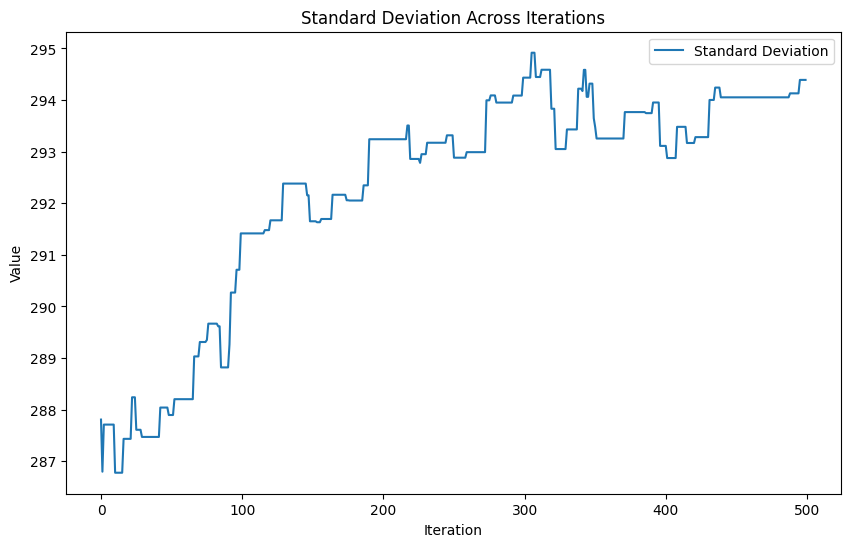

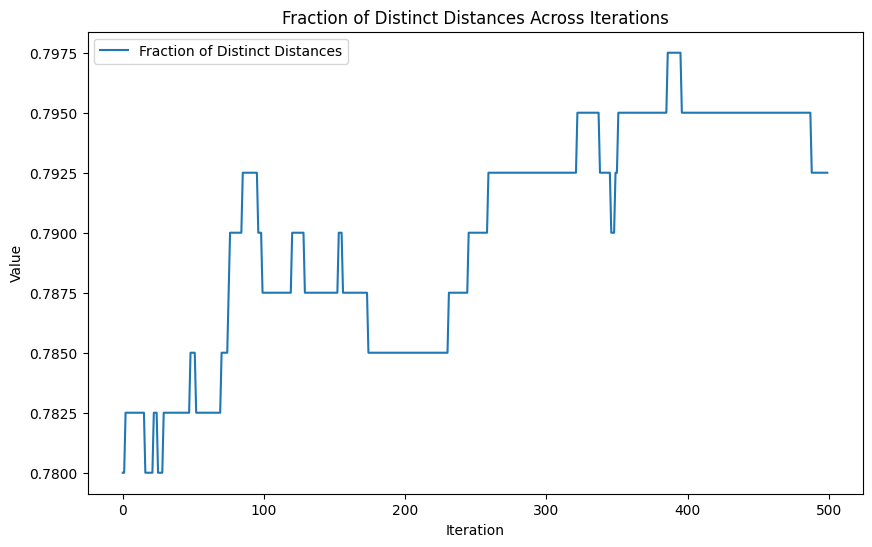

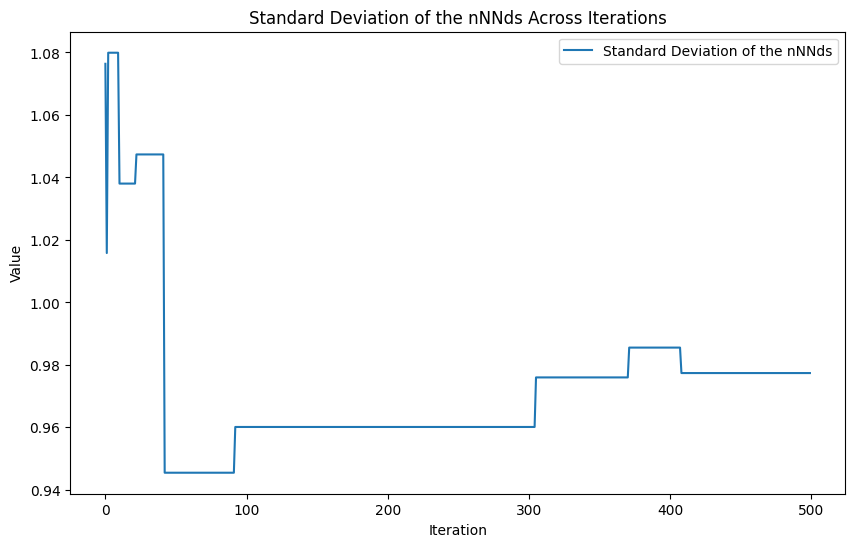

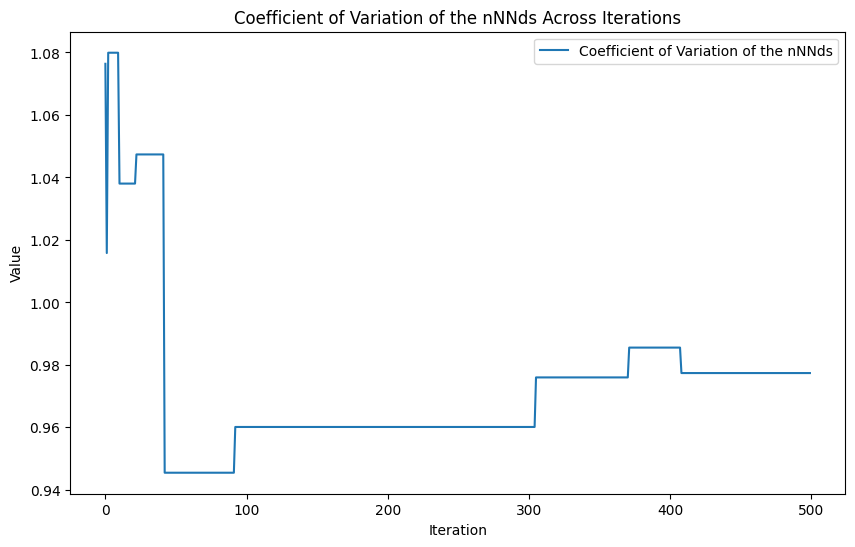

In [15]:
path = f"Results/results20_1000_0.json"
loaded = load_result(path)
l = []

hardest_matrices = []
for values in loaded.values():
    if values[0] > values[1]:
        hardest_matrices.append(values[4])
    else:
        hardest_matrices.append(hardest_matrices[-1])

for x in hardest_matrices:
    # Excluding infinite values for some calculations
    finite_distances = np.ma.masked_invalid(x)

    # 1. Standard Deviation (SD)
    sd = np.std(finite_distances)

    # 4. Fraction of Distinct Distances
    unique_distances = np.unique(finite_distances)
    fraction_distinct = unique_distances.size / finite_distances.size

    # 6. Standard Deviation of the Normalized Nearest-Neighbour Distances (nNNd)
    nearest = np.min(x, axis=1)
    mean_nearest = np.mean(nearest)
    normalized_nNNd = nearest / mean_nearest
    sd_nNNd = np.std(normalized_nNNd)

    # 7. Coefficient of Variation of the nNNds
    cv_nNNd = sd_nNNd / np.mean(normalized_nNNd)

    l.append([sd, fraction_distinct, sd_nNNd, cv_nNNd])

data = np.array(l)
for i, x in enumerate(['Standard Deviation', 'Fraction of Distinct Distances', 
                        'Standard Deviation of the nNNds',
                        'Coefficient of Variation of the nNNds']):
    plt.figure(figsize=(10, 6))
    plt.plot(data[:, i], label=x)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{x} Across Iterations')
    plt.legend()
    plt.show()

We observe that the last two graphs are the same, so I drop the last characteristic for now

### Analysis 5: The relationship between hardness and characteristics

Going into the analysis of the characteristics, there are a couple of ways we could continue. We want to calculate the relationship between hardness and the characteristics, but how do we represent hardness? 

I could take all the matrices I have calculated so far and compare their hardness to the characteristics directly. But as we have seen, their hardness is really chaotic: in analysis 3 we observed how even past mutation 400, a problem instance of hardness ~2500 is only one mutation away from an extremely easy problem instance. So, it will be really hard to get a clear view on the relationship between this data and the characteristics. 

I could sort them by hardness, but then we lose their evolutionary order. Then the characteristics are not really evolving with the hardness anymore. This is not necessarily a bad thing, but me and my supervisor agreed it would take away from the story of the thesis.

So, we chose to calculate the characteristics over the hardest matrix found so far at each mutation step. This also means we will start seeing plateauing for every characteristic according to the hill climber. This is because it sometimes takes 100 mutations to find the next hardest matrix, during which the characteristic stays the same. Importantly, duplicates will skew the pearson correlation results, making them more significant as they should be. So we should remove the duplicates before calculating correlation.

#### Standard deviation

20 cities, between 1 and 1000, pearson statistic: 0.704, Pvalue: 0.0
Pvalue rounded to 10 decimals


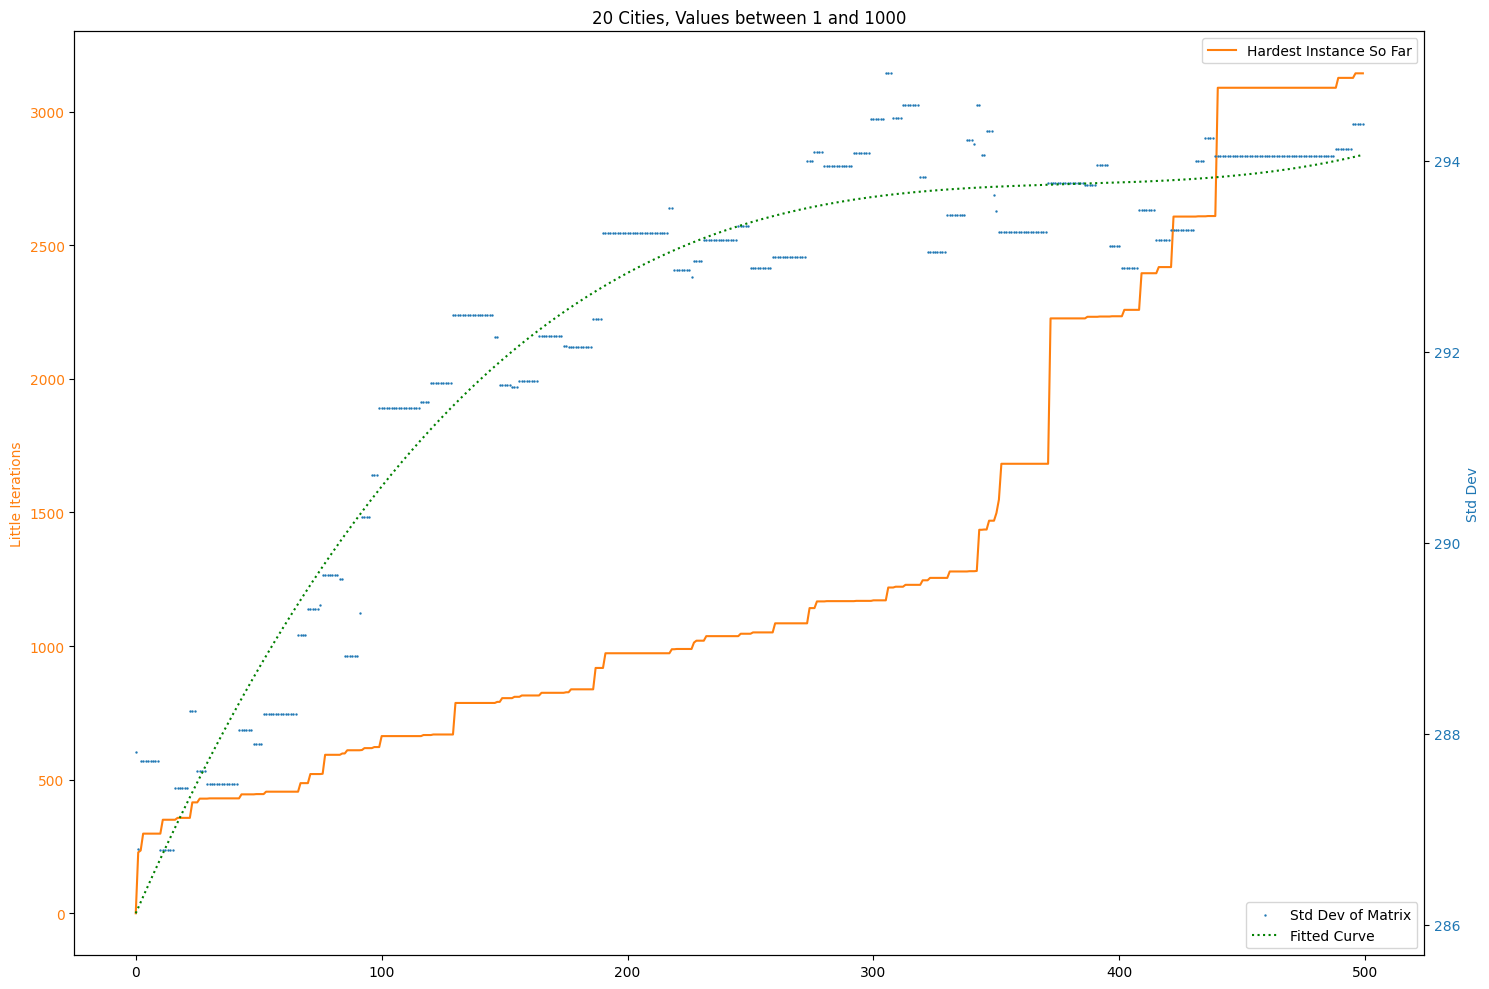

In [16]:
from scipy.stats import pearsonr

cities = [20]
ranges = [1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)
        
        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])
        
        # these are just list comprehensions but instead of lists they are numpy arrays
        # numpy arrays make it easy to remove duplicates before we get to the correlation calculation
        y_values_std = np.fromiter((np.std(np.ma.masked_invalid(x)) for x in hardest_matrices), float)
        y_values = np.fromiter((values[1] for values in loaded.values()), float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_std, label='Std Dev of Matrix', color=color, s=0.5)
        ax2.set_ylabel('Std Dev', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_std, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')
        
        # remove duplicates before pearson correlation
        y_values_std = y_values_std[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_std, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_std, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")

plt.tight_layout()
plt.show()

#### Fraction of Distinct Distances

20 cities, between 1 and 1000, pearson statistic: 0.746, Pvalue: 0.0
Pvalue rounded to 10 decimals


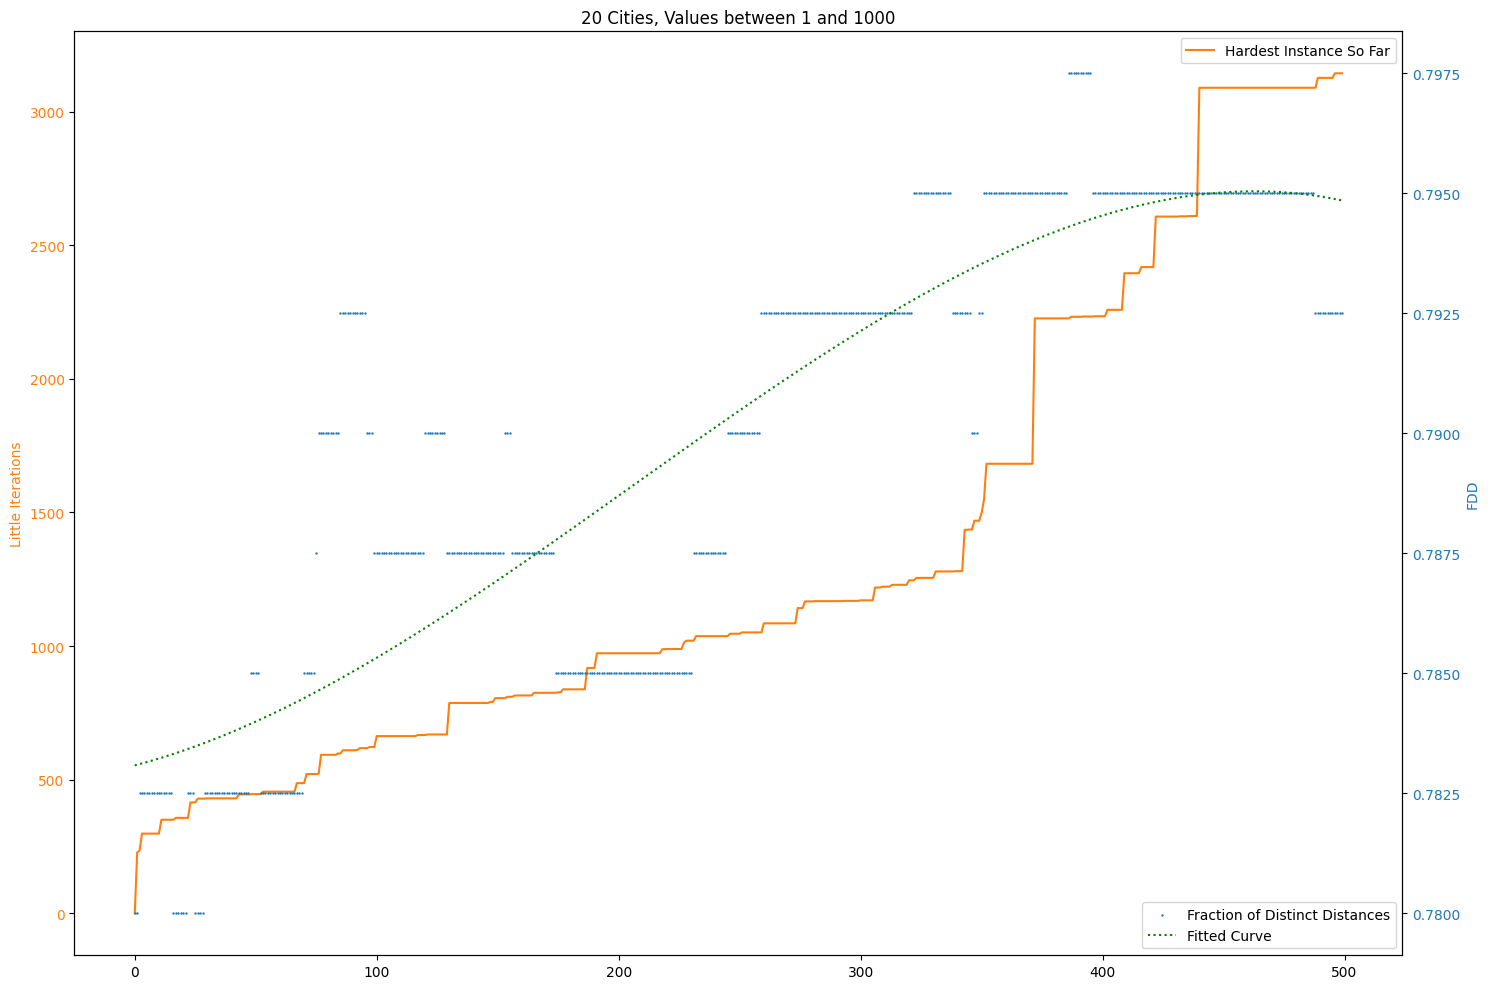

In [17]:
cities = [20]
ranges = [1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])

        finite_distances = [np.ma.masked_invalid(x) for x in hardest_matrices]
        y_values_fdd = np.fromiter((np.unique(values).size / values.size for values in finite_distances),float)
        y_values = np.fromiter((values[1] for values in loaded.values()),float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_fdd, label='Fraction of Distinct Distances', color=color, s=0.5)
        ax2.set_ylabel('FDD', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        x_values = range(500)
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_fdd, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')

        y_values_fdd = y_values_fdd[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_fdd, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_fdd, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")
    
plt.tight_layout()
plt.show()

#### Std Dev of nNNds

20 cities, between 1 and 1000, pearson statistic: -0.137, Pvalue: 0.2452008422
Pvalue rounded to 10 decimals


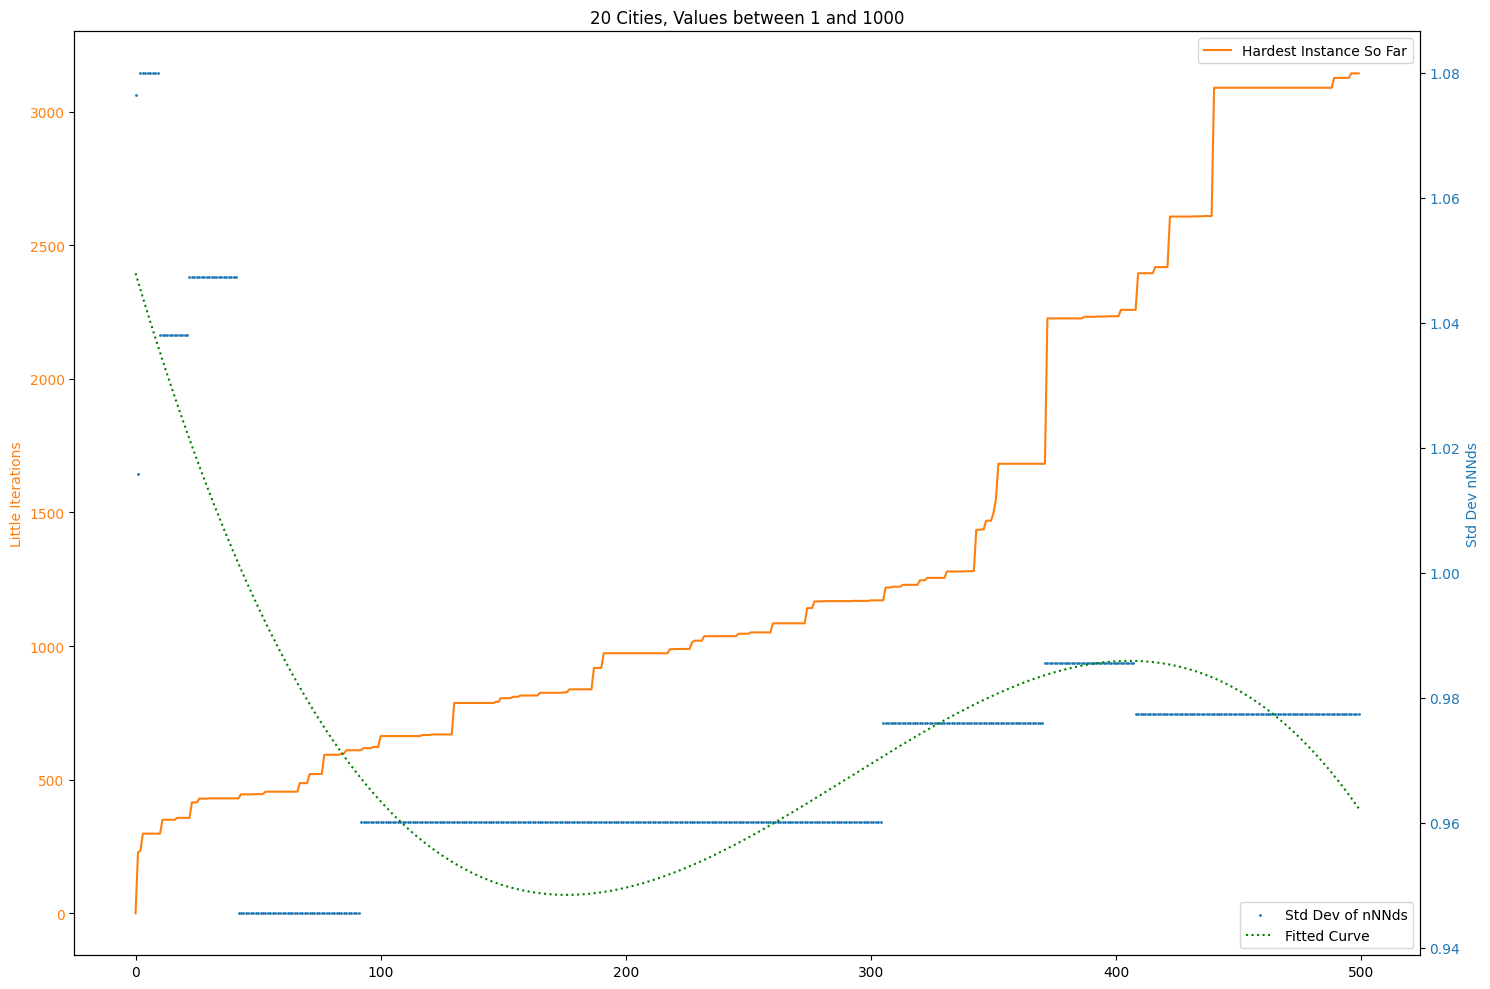

In [18]:
cities = [20]
ranges = [1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])
        
        y_values_nearest = [np.min(x, axis=1) for x in hardest_matrices]
        y_values_mean_nearest = [np.mean(values) for values in y_values_nearest]
        # normalize distances and take std
        y_values_sd_nNNd = np.fromiter((np.std(x/y) for x,y in zip(y_values_nearest,y_values_mean_nearest)),float)

        y_values = np.fromiter((values[1] for values in loaded.values()),float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_sd_nNNd, label='Std Dev of nNNds', color=color, s=1)
        ax2.set_ylabel('Std Dev nNNds', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        x_values = range(500)
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_sd_nNNd, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')

        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')

        y_values_sd_nNNd = y_values_sd_nNNd[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_sd_nNNd, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_sd_nNNd, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")

plt.tight_layout()
plt.show()